In [2]:
!pip install optuna

In [3]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [4]:
!pip install lightgbm==3.3.5

In [5]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (1.0.2)


In [6]:
!pip install imblearn

In [7]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score,\
classification_report, auc, recall_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import optuna
from lightgbm import LGBMClassifier
import joblib
import warnings

In [8]:
warnings.filterwarnings('ignore')

In [9]:
def makeConfusionMatrixandScore(model,y_actual,X_set,thresh=0.5):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x > thresh else 0)
    
    cm = confusion_matrix(y_actual,np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred))
    

In [10]:
def optimizedf1(y_test, y_pred_proc):
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc,pos_label=1)
    
    fscore = np.nan_to_num((2 * precision * recall) / (precision + recall))
    
    index = np.argmax(fscore)
    
    return thresholds[index]

In [11]:
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

In [12]:
X_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/LGBM/X_train.csv")
y_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/y_train.csv")["FAFXNT_BIN"]
X_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/LGBM/X_validation.csv")
y_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/merged_data/y_validation.csv")["FAFXNT_BIN"]

In [13]:
X_train = X_train.values
X_validation = X_validation.values
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()

In [16]:

def objective(trial):
        
    
    
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        "scale_pos_weight":2.33,
        'verbosity': -1,
        'num_threads':4
        
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_scores = []
        
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        sm = SMOTE(random_state=42)
        X_train_fold, y_train_fold = sm.fit_resample(X_train_fold,y_train_fold)
        train_data = lgb.Dataset(data=X_train_fold, label=y_train_fold)
        

        bst = lgb.train(param, train_data,verbose_eval=False)
        preds = bst.predict(X_val_fold)
        
        auc = roc_auc_score(y_val_fold, preds)  
        auc_scores.append(auc)
    print(f"Mean Score:{np.mean(auc_scores):.2f} trial scores:")
    print(*auc_scores, sep=",")
    return np.mean(auc_scores)
    

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
 

[I 2023-07-20 16:20:06,249] A new study created in memory with name: no-name-58ead8ad-0e8a-4473-8be5-4c7821b83043
[I 2023-07-20 16:20:09,925] Trial 0 finished with value: 0.6050401024714807 and parameters: {'lambda_l1': 0.0291359962746723, 'lambda_l2': 4.630932147961849e-07, 'num_leaves': 240, 'feature_fraction': 0.5267527290120796, 'bagging_fraction': 0.7994013634917141, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 0 with value: 0.6050401024714807.


Mean Score:0.61 trial scores:
0.6228226253561806,0.5997563145476347,0.5897639216596399,0.5994017457677381,0.6134559050262104


[I 2023-07-20 16:20:13,395] Trial 1 finished with value: 0.595684285034583 and parameters: {'lambda_l1': 3.3524025460967615e-07, 'lambda_l2': 5.399990839442057e-08, 'num_leaves': 127, 'feature_fraction': 0.6349031399430888, 'bagging_fraction': 0.48648317509140354, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 0 with value: 0.6050401024714807.


Mean Score:0.60 trial scores:
0.5885454943978133,0.6167820626877603,0.5971131654611328,0.5876558490955273,0.5883248535306814


[I 2023-07-20 16:20:18,695] Trial 2 finished with value: 0.6100793582041292 and parameters: {'lambda_l1': 1.067329498507157, 'lambda_l2': 0.03271375589696154, 'num_leaves': 246, 'feature_fraction': 0.7693950726777385, 'bagging_fraction': 0.8786067335038019, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 2 with value: 0.6100793582041292.


Mean Score:0.61 trial scores:
0.6336982168413725,0.5838458463879111,0.6151059193646128,0.6050168259002823,0.6127299825264673


[I 2023-07-20 16:20:19,861] Trial 3 finished with value: 0.6333758830281362 and parameters: {'lambda_l1': 0.0007641563999046721, 'lambda_l2': 0.05662460272864694, 'num_leaves': 5, 'feature_fraction': 0.7851986797115325, 'bagging_fraction': 0.8760959237242416, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.63 trial scores:
0.6610967134697456,0.612488557098467,0.6216622184401552,0.6361028378395802,0.635529088292733


[I 2023-07-20 16:20:25,071] Trial 4 finished with value: 0.6074939685537638 and parameters: {'lambda_l1': 0.0025504054504275247, 'lambda_l2': 0.004240452264119606, 'num_leaves': 162, 'feature_fraction': 0.7971887000108222, 'bagging_fraction': 0.7117016630669943, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.61 trial scores:
0.6444126406993386,0.5933096094586057,0.597403267190139,0.6020642349695071,0.6002800904512283


[I 2023-07-20 16:20:27,952] Trial 5 finished with value: 0.6069587215206964 and parameters: {'lambda_l1': 1.211965745473809e-08, 'lambda_l2': 0.0003299780345081982, 'num_leaves': 64, 'feature_fraction': 0.7669807774578593, 'bagging_fraction': 0.7997557973846537, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.61 trial scores:
0.6295916656996609,0.5870627522273366,0.616266326280638,0.5958560579687722,0.6060168054270737


[I 2023-07-20 16:20:33,542] Trial 6 finished with value: 0.6064520068728119 and parameters: {'lambda_l1': 4.6583180920334626e-05, 'lambda_l2': 0.00017188201366031408, 'num_leaves': 196, 'feature_fraction': 0.7771127522538943, 'bagging_fraction': 0.8635371055362757, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.61 trial scores:
0.630939027063268,0.5911306231385138,0.6023994636341367,0.5981059580448433,0.6096849624832974


[I 2023-07-20 16:20:34,522] Trial 7 finished with value: 0.6138160215158852 and parameters: {'lambda_l1': 0.8083510684920553, 'lambda_l2': 0.01721922571298151, 'num_leaves': 2, 'feature_fraction': 0.5836830126706676, 'bagging_fraction': 0.8954347158447304, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.61 trial scores:
0.6270291004267718,0.600185020436055,0.6138036849366288,0.5999819492257508,0.6280803525542193


[I 2023-07-20 16:20:37,572] Trial 8 finished with value: 0.600063507599083 and parameters: {'lambda_l1': 1.1483319062797269e-07, 'lambda_l2': 1.760217977501755e-07, 'num_leaves': 81, 'feature_fraction': 0.7420040533970423, 'bagging_fraction': 0.7853143398230512, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.60 trial scores:
0.6066027153521836,0.5799649299243157,0.6195605925811318,0.6030828143735737,0.5911064857642101


[I 2023-07-20 16:20:40,950] Trial 9 finished with value: 0.6038705901560336 and parameters: {'lambda_l1': 3.283869933231154e-05, 'lambda_l2': 1.0238825380623131e-05, 'num_leaves': 125, 'feature_fraction': 0.5308325133279879, 'bagging_fraction': 0.5971596685348036, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 3 with value: 0.6333758830281362.


Mean Score:0.60 trial scores:
0.627412679379569,0.5916528062507252,0.5884036668858547,0.6111347490297709,0.600749049234248


[I 2023-07-20 16:20:42,279] Trial 10 finished with value: 0.634657696031808 and parameters: {'lambda_l1': 0.0014342864001474084, 'lambda_l2': 2.4536621482048435, 'num_leaves': 9, 'feature_fraction': 0.4069812796542428, 'bagging_fraction': 0.9788246516448807, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.6626181358707565,0.6214752639925734,0.6219200866437165,0.632041413633492,0.6352335800185014


[I 2023-07-20 16:20:43,311] Trial 11 finished with value: 0.6293062024723725 and parameters: {'lambda_l1': 0.000824167429173226, 'lambda_l2': 6.719041089095859, 'num_leaves': 3, 'feature_fraction': 0.4019698636430876, 'bagging_fraction': 0.98408801459436, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.649640918526541,0.6213076496602585,0.6175298804780878,0.6227001379594889,0.6353524257374858


[I 2023-07-20 16:20:45,673] Trial 12 finished with value: 0.6148013356582979 and parameters: {'lambda_l1': 0.01346337182117535, 'lambda_l2': 2.087896540204291, 'num_leaves': 48, 'feature_fraction': 0.6914787108550178, 'bagging_fraction': 0.972593676713735, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6357160355342384,0.6110380484534355,0.618935262187496,0.5998336750087031,0.6084836571076164


[I 2023-07-20 16:20:47,462] Trial 13 finished with value: 0.6136918416106224 and parameters: {'lambda_l1': 7.752716338003895e-05, 'lambda_l2': 0.28218754247879285, 'num_leaves': 35, 'feature_fraction': 0.40924854893554485, 'bagging_fraction': 0.9714764662738503, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6337755773024407,0.5984669735298289,0.6053069276292886,0.6050039324901044,0.6259057971014493


[I 2023-07-20 16:20:50,967] Trial 14 finished with value: 0.6148590168215349 and parameters: {'lambda_l1': 0.025163727132205705, 'lambda_l2': 0.377276615463831, 'num_leaves': 92, 'feature_fraction': 0.699759700245649, 'bagging_fraction': 0.9056212135938266, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6303910571307005,0.5968810840779277,0.6222101883727227,0.615847290449851,0.6089654640764725


[I 2023-07-20 16:20:52,773] Trial 15 finished with value: 0.6293925297525578 and parameters: {'lambda_l1': 8.512644407810896, 'lambda_l2': 6.191119888384333, 'num_leaves': 24, 'feature_fraction': 0.4813888804901803, 'bagging_fraction': 0.9978795606862547, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.6540891450379711,0.6202117097951237,0.6192575974419474,0.6170528243014994,0.6363513721862474


[I 2023-07-20 16:20:55,491] Trial 16 finished with value: 0.6036078653551235 and parameters: {'lambda_l1': 6.657512372369587e-06, 'lambda_l2': 0.23314441357852775, 'num_leaves': 96, 'feature_fraction': 0.6389689752738767, 'bagging_fraction': 0.6992849937508605, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.60 trial scores:
0.6184066323701957,0.5982929124924252,0.6108768808262097,0.5992985984863136,0.5911643026004728


[I 2023-07-20 16:20:57,867] Trial 17 finished with value: 0.6080584583917588 and parameters: {'lambda_l1': 0.00045308776553321356, 'lambda_l2': 0.7150593932446127, 'num_leaves': 48, 'feature_fraction': 0.46039604999703415, 'bagging_fraction': 0.9161150022628166, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6208950605345608,0.5972098660374682,0.6025670779664514,0.6080080970615918,0.6116121903587214


[I 2023-07-20 16:20:59,424] Trial 18 finished with value: 0.6137159321205807 and parameters: {'lambda_l1': 0.0024137123302377162, 'lambda_l2': 0.0430570167667899, 'num_leaves': 23, 'feature_fraction': 0.5885592901154386, 'bagging_fraction': 0.41059483764309196, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6444706610451398,0.6187998813806264,0.596913317603373,0.6002269240191339,0.6081688765546305


[I 2023-07-20 16:21:02,047] Trial 19 finished with value: 0.6202232307707678 and parameters: {'lambda_l1': 4.023623940947896e-06, 'lambda_l2': 9.522991440965342, 'num_leaves': 178, 'feature_fraction': 0.7059479725261124, 'bagging_fraction': 0.8496587541739242, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.62 trial scores:
0.6478938614474142,0.5887646823708403,0.6321252207996493,0.6095037326422466,0.622828656593689


[I 2023-07-20 16:21:04,733] Trial 20 finished with value: 0.6039577981927018 and parameters: {'lambda_l1': 0.00017700734412707516, 'lambda_l2': 0.003707965460011882, 'num_leaves': 58, 'feature_fraction': 0.6412751627786725, 'bagging_fraction': 0.9420725455334288, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.60 trial scores:
0.6154282546190644,0.6140422130249229,0.5858830051960443,0.6085173867636251,0.5959181313598519


[I 2023-07-20 16:21:06,332] Trial 21 finished with value: 0.6249003494547516 and parameters: {'lambda_l1': 3.309833872065742, 'lambda_l2': 2.182760627210891, 'num_leaves': 24, 'feature_fraction': 0.4438604529729454, 'bagging_fraction': 0.9936468614214694, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.62 trial scores:
0.6415696437550767,0.6216622184401552,0.6148802846864967,0.6226936912543998,0.6236959091376298


[I 2023-07-20 16:21:07,428] Trial 22 finished with value: 0.6272428118313891 and parameters: {'lambda_l1': 0.10771452027485616, 'lambda_l2': 7.02065381237062, 'num_leaves': 3, 'feature_fraction': 0.4845303473644915, 'bagging_fraction': 0.9983103499092422, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.6454860170966619,0.6203825474799829,0.613723101123016,0.6188063280857153,0.6378160653715695


[I 2023-07-20 16:21:09,045] Trial 23 finished with value: 0.6268708979757653 and parameters: {'lambda_l1': 8.239809291610177, 'lambda_l2': 1.028916865823991, 'num_leaves': 26, 'feature_fraction': 0.5055983609463224, 'bagging_fraction': 0.9355281889645526, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.651394422310757,0.602670225247876,0.6132428215938833,0.6201601361544115,0.6468868845718985


[I 2023-07-20 16:21:11,379] Trial 24 finished with value: 0.6073363482543406 and parameters: {'lambda_l1': 0.23009666910019072, 'lambda_l2': 0.09738905279085806, 'num_leaves': 70, 'feature_fraction': 0.4388732044688398, 'bagging_fraction': 0.9398017797979307, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6187547544450032,0.5998272283036141,0.5947601181036373,0.6024574839799379,0.6208821564395107


[I 2023-07-20 16:21:13,391] Trial 25 finished with value: 0.6144073377128864 and parameters: {'lambda_l1': 0.006127330889924111, 'lambda_l2': 1.2837227296343818, 'num_leaves': 34, 'feature_fraction': 0.5497672537471381, 'bagging_fraction': 0.9994340498396207, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6293080106757436,0.6013164171791797,0.6108768808262097,0.6136618574246703,0.6168735224586288


[I 2023-07-20 16:21:14,920] Trial 26 finished with value: 0.6116968349206601 and parameters: {'lambda_l1': 0.15652708404189977, 'lambda_l2': 0.12751573419822343, 'num_leaves': 20, 'feature_fraction': 0.4777794708021225, 'bagging_fraction': 0.8500884256469653, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6310099408192472,0.5888162560115525,0.6094070320659112,0.6137714514111837,0.6154794942954055


[I 2023-07-20 16:21:17,657] Trial 27 finished with value: 0.6036902551605875 and parameters: {'lambda_l1': 0.003454906571913085, 'lambda_l2': 3.1509768452387106, 'num_leaves': 98, 'feature_fraction': 0.43592085084544574, 'bagging_fraction': 0.9436279853023382, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.60 trial scores:
0.6163372400366173,0.5873270671359868,0.6045526631338722,0.6060676388297941,0.6041666666666667


[I 2023-07-20 16:21:19,714] Trial 28 finished with value: 0.6111140740509617 and parameters: {'lambda_l1': 0.0008212362604127732, 'lambda_l2': 0.5059639655316647, 'num_leaves': 42, 'feature_fraction': 0.49997564193331073, 'bagging_fraction': 0.8889855257523454, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6418210652535489,0.5933934166247631,0.607589061230805,0.6028120527598345,0.6099547743858568


[I 2023-07-20 16:21:22,317] Trial 29 finished with value: 0.6063608810663143 and parameters: {'lambda_l1': 0.0794189613737906, 'lambda_l2': 1.5669434578338335, 'num_leaves': 206, 'feature_fraction': 0.5276359622281157, 'bagging_fraction': 0.9402663229441773, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6403898967237845,0.5875140215835687,0.5874495545326783,0.6018643871117472,0.6145865453797924


[I 2023-07-20 16:21:25,382] Trial 30 finished with value: 0.6074957851807898 and parameters: {'lambda_l1': 0.022501335041384952, 'lambda_l2': 0.14011336796807108, 'num_leaves': 110, 'feature_fraction': 0.5566918963689822, 'bagging_fraction': 0.8204789681712281, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.61 trial scores:
0.6276576541729522,0.5892223984321614,0.6090331231707474,0.6010456555654404,0.6105200945626477


[I 2023-07-20 16:21:26,445] Trial 31 finished with value: 0.6300296293090504 and parameters: {'lambda_l1': 0.0013932923677082445, 'lambda_l2': 6.6830559663412945, 'num_leaves': 4, 'feature_fraction': 0.40904743173108116, 'bagging_fraction': 0.961807725342577, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.6550239172758804,0.6227001379594889,0.6135973903737799,0.6318673525960882,0.6269593483400144


[I 2023-07-20 16:21:27,981] Trial 32 finished with value: 0.6294816960032301 and parameters: {'lambda_l1': 0.009253250473548419, 'lambda_l2': 7.859465783666309, 'num_leaves': 11, 'feature_fraction': 0.4186106953997184, 'bagging_fraction': 0.9021470582502067, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.63 trial scores:
0.6446124885570985,0.6164726208434869,0.626284505988989,0.6313000425482536,0.6287388220783227


[I 2023-07-20 16:21:29,378] Trial 33 finished with value: 0.622305898188091 and parameters: {'lambda_l1': 0.008090841998822918, 'lambda_l2': 0.7011573689593671, 'num_leaves': 13, 'feature_fraction': 0.4157674111553908, 'bagging_fraction': 0.9063295859981563, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.62 trial scores:
0.6336273030853932,0.6084400263025567,0.6189997292383863,0.6208499335989376,0.6296124987151813


[I 2023-07-20 16:21:31,874] Trial 34 finished with value: 0.6184637275551741 and parameters: {'lambda_l1': 0.0017723124155306434, 'lambda_l2': 2.9435208673266495, 'num_leaves': 52, 'feature_fraction': 0.42521868311799504, 'bagging_fraction': 0.8676573586977852, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.62 trial scores:
0.6439936048685517,0.6042303278794208,0.6028056060547454,0.6209272940600059,0.6203618049131463


[I 2023-07-20 16:21:34,506] Trial 35 finished with value: 0.6037809219151663 and parameters: {'lambda_l1': 0.00025084366219055125, 'lambda_l2': 0.8214945715640147, 'num_leaves': 153, 'feature_fraction': 0.451520281474577, 'bagging_fraction': 0.9482341127961615, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 10 with value: 0.634657696031808.


Mean Score:0.60 trial scores:
0.6201150092187883,0.6000979899173533,0.5965780889387434,0.5930388478448665,0.6090746736560797


[I 2023-07-20 16:21:35,877] Trial 36 finished with value: 0.6349236512422479 and parameters: {'lambda_l1': 0.0012127053372591073, 'lambda_l2': 6.848841456980805, 'num_leaves': 13, 'feature_fraction': 0.4107304048840749, 'bagging_fraction': 0.9047923861224584, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6528771644812337,0.620269730140925,0.6382947175698501,0.6357676091749507,0.62740903484428


[I 2023-07-20 16:21:38,525] Trial 37 finished with value: 0.6096288147234332 and parameters: {'lambda_l1': 0.0008173680776224885, 'lambda_l2': 0.06782774919177768, 'num_leaves': 254, 'feature_fraction': 0.4044380182246003, 'bagging_fraction': 0.8370033152871533, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6319318196469785,0.6035985507806959,0.6087688082620972,0.6013035237690018,0.6025413711583925


[I 2023-07-20 16:21:41,002] Trial 38 finished with value: 0.6033388009960264 and parameters: {'lambda_l1': 0.0017714328507553718, 'lambda_l2': 0.008814156785959856, 'num_leaves': 64, 'feature_fraction': 0.4635223639949332, 'bagging_fraction': 0.8795371998583281, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.60 trial scores:
0.6307327325004191,0.5844518366662799,0.5938575793911732,0.6134039892211091,0.5942478672011512


[I 2023-07-20 16:21:43,803] Trial 39 finished with value: 0.6089903715567125 and parameters: {'lambda_l1': 0.00014888218597278123, 'lambda_l2': 0.02644805159227462, 'num_leaves': 76, 'feature_fraction': 0.43032617124567313, 'bagging_fraction': 0.7917372352007767, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6421240603927333,0.5919235678644644,0.5988731159504377,0.6000206294562849,0.6120104841196423


[I 2023-07-20 16:21:45,852] Trial 40 finished with value: 0.6024868260796292 and parameters: {'lambda_l1': 0.00032309446481458597, 'lambda_l2': 0.31701305758364395, 'num_leaves': 40, 'feature_fraction': 0.45974044397063396, 'bagging_fraction': 0.7695769017249997, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.60 trial scores:
0.6235897832617749,0.6034115963331141,0.6019997679186168,0.5932451424077154,0.5901878404769247


[I 2023-07-20 16:21:47,382] Trial 41 finished with value: 0.6329275383450039 and parameters: {'lambda_l1': 0.006279719416773272, 'lambda_l2': 9.62006205481639, 'num_leaves': 12, 'feature_fraction': 0.42514542461602717, 'bagging_fraction': 0.911436377369067, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6429363452339509,0.6210497814566975,0.6342526334790288,0.640518830825565,0.625880100729777


[I 2023-07-20 16:21:48,412] Trial 42 finished with value: 0.6132389950430424 and parameters: {'lambda_l1': 0.004862492939356968, 'lambda_l2': 3.210499012755314, 'num_leaves': 2, 'feature_fraction': 0.42914003283876634, 'bagging_fraction': 0.9566657027875981, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6283732384378344,0.5951501437615234,0.6140808932554571,0.5958657280264057,0.6327249717339911


[I 2023-07-20 16:21:49,903] Trial 43 finished with value: 0.6323270025198446 and parameters: {'lambda_l1': 0.032369840509174186, 'lambda_l2': 9.448319897915603, 'num_leaves': 13, 'feature_fraction': 0.4069231300346434, 'bagging_fraction': 0.9198805495510937, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6459018295749043,0.6125594708544463,0.6250596320220735,0.6398354800861279,0.6382786000616713


[I 2023-07-20 16:21:52,079] Trial 44 finished with value: 0.6142906987181498 and parameters: {'lambda_l1': 0.03907403942673767, 'lambda_l2': 2.1984873920837726, 'num_leaves': 32, 'feature_fraction': 0.7935168311979262, 'bagging_fraction': 0.8757893049410469, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6369022292706198,0.6005750460939413,0.619618612926933,0.6021287020203975,0.612228903278857


[I 2023-07-20 16:21:53,586] Trial 45 finished with value: 0.6281409690505795 and parameters: {'lambda_l1': 0.013836582699741595, 'lambda_l2': 0.5141308618514222, 'num_leaves': 16, 'feature_fraction': 0.40370367605433766, 'bagging_fraction': 0.9118267061588397, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6431490865018887,0.6174396266068414,0.6298817674286672,0.6309196869480009,0.6193146777674992


[I 2023-07-20 16:21:56,813] Trial 46 finished with value: 0.6110083372038413 and parameters: {'lambda_l1': 0.004508372347929862, 'lambda_l2': 3.626865311691482, 'num_leaves': 235, 'feature_fraction': 0.43286694597839437, 'bagging_fraction': 0.9707454852334662, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6257881096971337,0.6043205817506673,0.6100065756391908,0.5939671733776867,0.6209592455545278


[I 2023-07-20 16:21:58,280] Trial 47 finished with value: 0.6302598293596324 and parameters: {'lambda_l1': 0.034889370356529385, 'lambda_l2': 9.936824915117619, 'num_leaves': 14, 'feature_fraction': 0.4015009668338632, 'bagging_fraction': 0.9186311354217944, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6428203045423484,0.61937363813355,0.6278059283899999,0.631667504738328,0.6296317709939357


[I 2023-07-20 16:22:00,280] Trial 48 finished with value: 0.6196697986322466 and parameters: {'lambda_l1': 0.0005713624679474867, 'lambda_l2': 0.2084379977000536, 'num_leaves': 36, 'feature_fraction': 0.45134114023488914, 'bagging_fraction': 0.8776484718718922, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.62 trial scores:
0.6315321239314586,0.5943604223881174,0.6167885093928493,0.6214172436467722,0.6342506938020351


[I 2023-07-20 16:22:04,106] Trial 49 finished with value: 0.5999047716499332 and parameters: {'lambda_l1': 7.431161076575408e-05, 'lambda_l2': 1.1011391178148402, 'num_leaves': 147, 'feature_fraction': 0.471761768214521, 'bagging_fraction': 0.8296348936828049, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.60 trial scores:
0.6148609445712296,0.5864309751286118,0.5889709769336892,0.6087881483773643,0.6004728132387707


[I 2023-07-20 16:22:06,582] Trial 50 finished with value: 0.6087634602600309 and parameters: {'lambda_l1': 0.003061105631280839, 'lambda_l2': 1.5043581327682487, 'num_leaves': 53, 'feature_fraction': 0.6118746622039745, 'bagging_fraction': 0.9693929014409096, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6510398535308604,0.588919403292977,0.6071829188101961,0.6066607356979848,0.5900143899681365


[I 2023-07-20 16:22:08,103] Trial 51 finished with value: 0.6325808385509003 and parameters: {'lambda_l1': 0.05367181123077519, 'lambda_l2': 9.883928007730349, 'num_leaves': 16, 'feature_fraction': 0.42355253051237585, 'bagging_fraction': 0.9161032347480671, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6465593934939852,0.6258848102734692,0.6290114622416482,0.6284312587836356,0.6330172679617637


[I 2023-07-20 16:22:09,442] Trial 52 finished with value: 0.6300787608353 and parameters: {'lambda_l1': 0.35898970734816105, 'lambda_l2': 5.129124854597341, 'num_leaves': 12, 'feature_fraction': 0.4191778975294362, 'bagging_fraction': 0.9241968643280604, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.63 trial scores:
0.6524065550097344,0.606048298714527,0.6282571977462319,0.6332533941902293,0.6304283585157775


[I 2023-07-20 16:22:11,161] Trial 53 finished with value: 0.6167277431840387 and parameters: {'lambda_l1': 0.06431205268522033, 'lambda_l2': 3.638011697610765, 'num_leaves': 28, 'feature_fraction': 0.44791884575411767, 'bagging_fraction': 0.8888660446503058, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.62 trial scores:
0.638288270864761,0.6030763676684846,0.6108446473007646,0.6194703387098854,0.6119590913762977


[I 2023-07-20 16:22:13,226] Trial 54 finished with value: 0.6102441925812383 and parameters: {'lambda_l1': 0.01930003964196746, 'lambda_l2': 0.3515767775372015, 'num_leaves': 44, 'feature_fraction': 0.4303413714631048, 'bagging_fraction': 0.917538714094756, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.61 trial scores:
0.6371343106538248,0.5763160948439253,0.6060869789450612,0.6095101793473355,0.6221733991160447


[I 2023-07-20 16:22:14,831] Trial 55 finished with value: 0.6231283376831597 and parameters: {'lambda_l1': 0.012501264380785974, 'lambda_l2': 8.349651547661376, 'num_leaves': 22, 'feature_fraction': 0.4166702958550901, 'bagging_fraction': 0.8609161028424257, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 36 with value: 0.6349236512422479.


Mean Score:0.62 trial scores:
0.6440451785092639,0.6215332843383746,0.6125852576748023,0.6149640918526542,0.6225138760407031


[I 2023-07-20 16:22:16,163] Trial 56 finished with value: 0.6369976903521076 and parameters: {'lambda_l1': 0.04622186157543521, 'lambda_l2': 1.7721577087860987, 'num_leaves': 9, 'feature_fraction': 0.4439753874254156, 'bagging_fraction': 0.9754632727319832, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.64 trial scores:
0.6647197617297799,0.6206694258564448,0.6298430871981331,0.6397903531505048,0.6299658238256758


[I 2023-07-20 16:22:18,238] Trial 57 finished with value: 0.6158495527105846 and parameters: {'lambda_l1': 0.001453483434599292, 'lambda_l2': 1.7378776850157227, 'num_leaves': 31, 'feature_fraction': 0.7483799020834124, 'bagging_fraction': 0.9841286237636858, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6366894880026818,0.6060225118941709,0.6183743988447504,0.6059902783687257,0.6121710864425943


[I 2023-07-20 16:22:19,325] Trial 58 finished with value: 0.6298295862908612 and parameters: {'lambda_l1': 0.635064922695193, 'lambda_l2': 0.8080503512789954, 'num_leaves': 3, 'feature_fraction': 0.49473763755308936, 'bagging_fraction': 0.9686009676704833, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.64984721308939,0.624041052618007,0.6189288154824069,0.6226840211967664,0.6336468290677357


[I 2023-07-20 16:22:21,950] Trial 59 finished with value: 0.6097756015069061 and parameters: {'lambda_l1': 0.06870034463868113, 'lambda_l2': 0.20273101118643955, 'num_leaves': 85, 'feature_fraction': 0.4682390875761433, 'bagging_fraction': 0.9549487421688067, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6408218259647493,0.6044301757371807,0.6088848489536998,0.588255392668807,0.6064857642100936


[I 2023-07-20 16:22:24,170] Trial 60 finished with value: 0.6138057911485344 and parameters: {'lambda_l1': 0.006734073516855631, 'lambda_l2': 2.5393677228551232, 'num_leaves': 61, 'feature_fraction': 0.4434771878416351, 'bagging_fraction': 0.8933545864783562, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.640280302737271,0.587597828749726,0.6114248507587772,0.6081757113939065,0.6215502621029911


[I 2023-07-20 16:22:25,522] Trial 61 finished with value: 0.6347763968092615 and parameters: {'lambda_l1': 0.03183985672878142, 'lambda_l2': 4.139447148304643, 'num_leaves': 12, 'feature_fraction': 0.4015813052239002, 'bagging_fraction': 0.9247563357364851, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6526450830980285,0.6196508464523781,0.6277865882747328,0.6386815198751918,0.635117946345976


[I 2023-07-20 16:22:27,160] Trial 62 finished with value: 0.6213680064148352 and parameters: {'lambda_l1': 0.10976953931124898, 'lambda_l2': 4.2828713107439835, 'num_leaves': 24, 'feature_fraction': 0.4230165167674285, 'bagging_fraction': 0.9319039346370672, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6303588236052554,0.6110380484534355,0.6197733338490697,0.6262780592838999,0.6193917668825162


[I 2023-07-20 16:22:28,507] Trial 63 finished with value: 0.634394343059819 and parameters: {'lambda_l1': 0.0032816556075571553, 'lambda_l2': 1.242087559531086, 'num_leaves': 9, 'feature_fraction': 0.4449672636288537, 'bagging_fraction': 0.9829764144769468, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6550883843267705,0.61917379027579,0.6252530331747443,0.6440838587397981,0.628372648781992


[I 2023-07-20 16:22:29,874] Trial 64 finished with value: 0.6329205195768384 and parameters: {'lambda_l1': 0.002834127790785563, 'lambda_l2': 0.4925810030264811, 'num_leaves': 10, 'feature_fraction': 0.4427943554325103, 'bagging_fraction': 0.9814065274591786, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6513944223107571,0.6241893268350547,0.6329052721154219,0.6385783725937673,0.6175352040291912


[I 2023-07-20 16:22:31,904] Trial 65 finished with value: 0.6111929820790702 and parameters: {'lambda_l1': 0.0005176748008818743, 'lambda_l2': 1.6686189270742395, 'num_leaves': 39, 'feature_fraction': 0.45540033667229934, 'bagging_fraction': 0.9877955744741432, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.62714191776583,0.6062610399824649,0.5916914864812594,0.6194509985946184,0.6114194675711789


[I 2023-07-20 16:22:33,409] Trial 66 finished with value: 0.6158587965163715 and parameters: {'lambda_l1': 0.0010082922415371217, 'lambda_l2': 0.06348327694830196, 'num_leaves': 20, 'feature_fraction': 0.4003392940165725, 'bagging_fraction': 0.9540865296941623, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6253175002256347,0.608072564112482,0.6118052063590299,0.6167433824572262,0.617355329427485


[I 2023-07-20 16:22:34,412] Trial 67 finished with value: 0.6129200531796912 and parameters: {'lambda_l1': 0.015519366245203635, 'lambda_l2': 0.9862938918519139, 'num_leaves': 2, 'feature_fraction': 0.5132539507095757, 'bagging_fraction': 0.9323511556122109, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6249081344524813,0.5937866656351939,0.6168755399115512,0.5947149911680141,0.6343149347312159


[I 2023-07-20 16:22:35,666] Trial 68 finished with value: 0.6272477826823228 and parameters: {'lambda_l1': 0.005969628999100689, 'lambda_l2': 4.3242052955403665, 'num_leaves': 8, 'feature_fraction': 0.48604474345925314, 'bagging_fraction': 0.9796944040711413, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6429879188746632,0.6179360228986963,0.6201794762696785,0.6307907528462202,0.6243447425223558


[I 2023-07-20 16:22:37,345] Trial 69 finished with value: 0.6093665841599737 and parameters: {'lambda_l1': 0.0024718286536942126, 'lambda_l2': 0.13810322414594936, 'num_leaves': 27, 'feature_fraction': 0.4716134559246449, 'bagging_fraction': 0.9977222559375232, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6196572931574672,0.5889000631777098,0.6083497724313103,0.6138617052824302,0.6160640867509508


[I 2023-07-20 16:22:38,902] Trial 70 finished with value: 0.6192706673761501 and parameters: {'lambda_l1': 0.009489387096003265, 'lambda_l2': 0.443141059032219, 'num_leaves': 19, 'feature_fraction': 0.41372530972112276, 'bagging_fraction': 0.8973898995617506, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6375146662540775,0.6024316971595818,0.6287407006279092,0.6161954125246587,0.6114708603145236


[I 2023-07-20 16:22:40,303] Trial 71 finished with value: 0.6350739334200759 and parameters: {'lambda_l1': 0.002468005894558716, 'lambda_l2': 0.6144600029432382, 'num_leaves': 11, 'feature_fraction': 0.4368192236413916, 'bagging_fraction': 0.9791810531548858, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.64 trial scores:
0.6561843241919056,0.6186709472788458,0.6283667917327453,0.6475908663082299,0.6245567375886525


[I 2023-07-20 16:22:42,133] Trial 72 finished with value: 0.6127963041232549 and parameters: {'lambda_l1': 0.0013686684857535476, 'lambda_l2': 1.1403827130559858, 'num_leaves': 34, 'feature_fraction': 0.43929938524165046, 'bagging_fraction': 0.9446216564943883, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6268647094470015,0.5925037713224771,0.6141195734859912,0.6310163875243362,0.5994770788364683


[I 2023-07-20 16:22:43,251] Trial 73 finished with value: 0.6335285367505744 and parameters: {'lambda_l1': 0.003926350673072537, 'lambda_l2': 2.005202965866596, 'num_leaves': 6, 'feature_fraction': 0.45156363972973323, 'bagging_fraction': 0.9615327652314867, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6526064028674944,0.6204308977681506,0.6205920653953764,0.6373792854472079,0.6366340322746427


[I 2023-07-20 16:22:45,389] Trial 74 finished with value: 0.6098372076460491 and parameters: {'lambda_l1': 0.0008674346788793528, 'lambda_l2': 0.6575298506626694, 'num_leaves': 46, 'feature_fraction': 0.4593156203596191, 'bagging_fraction': 0.9599148581865719, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6237831844144458,0.5886357482690596,0.6024059103392255,0.6164855142536649,0.6178756809538494


[I 2023-07-20 16:22:48,386] Trial 75 finished with value: 0.6100449702109147 and parameters: {'lambda_l1': 0.0003830305272274728, 'lambda_l2': 2.259174673329564, 'num_leaves': 123, 'feature_fraction': 0.43777678947681126, 'bagging_fraction': 0.9982767913697354, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6271161309454738,0.6172397787490813,0.5975837749326318,0.599820781598525,0.6084643848288622


[I 2023-07-20 16:22:49,663] Trial 76 finished with value: 0.6340707098667553 and parameters: {'lambda_l1': 0.023768868022034036, 'lambda_l2': 0.25499345462461787, 'num_leaves': 9, 'feature_fraction': 0.4779078509078455, 'bagging_fraction': 0.9708254504262241, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6472234041181553,0.6283216647971223,0.6160664784228781,0.6485256385461391,0.6302163634494808


[I 2023-07-20 16:22:50,919] Trial 77 finished with value: 0.633429272898298 and parameters: {'lambda_l1': 0.024643321734136896, 'lambda_l2': 4.824166075407754, 'num_leaves': 8, 'feature_fraction': 0.4505733555642213, 'bagging_fraction': 0.975926825257872, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6577573202336285,0.6213398831857038,0.6270710040098506,0.6353550200492528,0.6256231370130537


[I 2023-07-20 16:22:52,655] Trial 78 finished with value: 0.6139015723289081 and parameters: {'lambda_l1': 0.003615169531581632, 'lambda_l2': 0.2563843710302954, 'num_leaves': 28, 'feature_fraction': 0.48336088702161834, 'bagging_fraction': 0.9496318400839374, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.628502172539615,0.5929679340888871,0.5964298147216958,0.6342461867739398,0.6173617535204029


[I 2023-07-20 16:22:54,437] Trial 79 finished with value: 0.6220062392635176 and parameters: {'lambda_l1': 0.009961903278522168, 'lambda_l2': 1.4250796006502489, 'num_leaves': 19, 'feature_fraction': 0.43249004165749755, 'bagging_fraction': 0.9339590765156938, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6438646707667711,0.6132428215938833,0.6177941953867377,0.6157505898735156,0.61937891869668


[I 2023-07-20 16:22:55,648] Trial 80 finished with value: 0.6339083225241192 and parameters: {'lambda_l1': 0.017635492762037144, 'lambda_l2': 0.6930573985882873, 'num_leaves': 9, 'feature_fraction': 0.41539284169476937, 'bagging_fraction': 0.9650558725129593, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6509689397748811,0.6130687605564795,0.626497247256927,0.6415631970499878,0.637443467982321


[I 2023-07-20 16:22:56,753] Trial 81 finished with value: 0.6343254639519514 and parameters: {'lambda_l1': 0.013945656989260041, 'lambda_l2': 0.6765875633272534, 'num_leaves': 7, 'feature_fraction': 0.41162316377779834, 'bagging_fraction': 0.9637853239973778, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6554493998117563,0.6205469384597532,0.6296819195709072,0.6422981214301371,0.6236509404872033


[I 2023-07-20 16:22:58,305] Trial 82 finished with value: 0.6229364090549397 and parameters: {'lambda_l1': 0.021876623025164542, 'lambda_l2': 0.6837511569162377, 'num_leaves': 17, 'feature_fraction': 0.41256855225901823, 'bagging_fraction': 0.9816909167388115, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6356386750731701,0.6102579971376629,0.631828672365554,0.6238605448755141,0.6130961558227978


[I 2023-07-20 16:22:59,353] Trial 83 finished with value: 0.634875710905285 and parameters: {'lambda_l1': 0.04628831261212593, 'lambda_l2': 0.18917656932509685, 'num_leaves': 7, 'feature_fraction': 0.41388970167581857, 'bagging_fraction': 0.9681500061454479, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6528255908405214,0.6204244510630618,0.6339754251602007,0.6375791333049678,0.6295739541576729


[I 2023-07-20 16:23:00,935] Trial 84 finished with value: 0.6147925286898355 and parameters: {'lambda_l1': 0.15703800152371739, 'lambda_l2': 0.3026683582626995, 'num_leaves': 23, 'feature_fraction': 0.40876805924365744, 'bagging_fraction': 0.9380272529834367, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6218878531182712,0.5949535192563081,0.6345427352080353,0.6089106357740559,0.6136679000925069


[I 2023-07-20 16:23:02,024] Trial 85 finished with value: 0.6134131643952297 and parameters: {'lambda_l1': 0.03853457596089376, 'lambda_l2': 0.12151258619333082, 'num_leaves': 2, 'feature_fraction': 0.40012673273601984, 'bagging_fraction': 0.9853979696841909, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6279896594850372,0.5944506762593638,0.6116762722572493,0.6012938537113681,0.6316553602631308


[I 2023-07-20 16:23:04,054] Trial 86 finished with value: 0.6081032742236674 and parameters: {'lambda_l1': 0.0495001157054374, 'lambda_l2': 0.04620202536456551, 'num_leaves': 37, 'feature_fraction': 0.42648588340530225, 'bagging_fraction': 0.9979654243083476, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6157119096429815,0.5956884436364573,0.606499568070759,0.6252143529442102,0.5974020968239285


[I 2023-07-20 16:23:06,154] Trial 87 finished with value: 0.6085342668237843 and parameters: {'lambda_l1': 0.0023243823773545615, 'lambda_l2': 2.9224275195347365, 'num_leaves': 52, 'feature_fraction': 0.4350388070163686, 'bagging_fraction': 0.9704080972500753, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6240346059129178,0.5909694555112882,0.6073634265526889,0.6050877396562617,0.6152161064857642


[I 2023-07-20 16:23:07,684] Trial 88 finished with value: 0.6277094798275521 and parameters: {'lambda_l1': 0.010581475241469277, 'lambda_l2': 0.07552246519083225, 'num_leaves': 15, 'feature_fraction': 0.41981471813470783, 'bagging_fraction': 0.9482733749887867, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6455021338593845,0.6013357572944468,0.6343364406451862,0.633188927139339,0.6241841401994038


[I 2023-07-20 16:23:11,717] Trial 89 finished with value: 0.6010823271394353 and parameters: {'lambda_l1': 0.028189722159695736, 'lambda_l2': 1.157075261605996, 'num_leaves': 189, 'feature_fraction': 0.46400353165827074, 'bagging_fraction': 0.932475807235673, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.60 trial scores:
0.6141647004216145,0.6166531285859796,0.5914594050980544,0.5905375262703232,0.5925968753212048


[I 2023-07-20 16:23:13,627] Trial 90 finished with value: 0.6049966538559126 and parameters: {'lambda_l1': 0.08141447870810914, 'lambda_l2': 0.19608389377024804, 'num_leaves': 31, 'feature_fraction': 0.4096914114584909, 'bagging_fraction': 0.9537962065112757, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.60 trial scores:
0.6271032375352956,0.5885068141672791,0.601367990819892,0.6134168826312871,0.5945883441258094


[I 2023-07-20 16:23:15,072] Trial 91 finished with value: 0.6304868818457156 and parameters: {'lambda_l1': 0.02092429264878763, 'lambda_l2': 0.5354495021686165, 'num_leaves': 9, 'feature_fraction': 0.41607803380699343, 'bagging_fraction': 0.9744698448865288, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6485578720715842,0.6105996725073815,0.6262780592839,0.648538531956317,0.6184602734093947


[I 2023-07-20 16:23:16,583] Trial 92 finished with value: 0.6311723694601559 and parameters: {'lambda_l1': 0.006358373113167576, 'lambda_l2': 0.3684258599579273, 'num_leaves': 10, 'feature_fraction': 0.43806065574243835, 'bagging_fraction': 0.962566372286101, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6470815766061966,0.6199087146559393,0.6319898399927797,0.6506143709949844,0.6062673450508789


[I 2023-07-20 16:23:18,481] Trial 93 finished with value: 0.6189117932389048 and parameters: {'lambda_l1': 0.013500295362654777, 'lambda_l2': 4.954573393359666, 'num_leaves': 24, 'feature_fraction': 0.4232291101521755, 'bagging_fraction': 0.9860465359225745, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6390812155907116,0.6148222643406955,0.6043979422117356,0.6186709472788458,0.6175865967725357


[I 2023-07-20 16:23:19,777] Trial 94 finished with value: 0.6332489103209729 and parameters: {'lambda_l1': 0.040775582955771626, 'lambda_l2': 0.8642174747791262, 'num_leaves': 8, 'feature_fraction': 0.4457499384645382, 'bagging_fraction': 0.9255818248014006, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6558748823476321,0.6167627225724932,0.6313580628940548,0.6350004512693563,0.6272484325213279


[I 2023-07-20 16:23:21,336] Trial 95 finished with value: 0.6263227490343193 and parameters: {'lambda_l1': 0.004782133057816177, 'lambda_l2': 2.4285407775512486, 'num_leaves': 18, 'feature_fraction': 0.41187678288140295, 'bagging_fraction': 0.9643125771883818, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6495248778349386,0.6063577405588004,0.6285537461803272,0.6293402442011888,0.6178371363963409


[I 2023-07-20 16:23:22,915] Trial 96 finished with value: 0.6272323074094961 and parameters: {'lambda_l1': 0.013923069829102644, 'lambda_l2': 5.601522339779465, 'num_leaves': 14, 'feature_fraction': 0.43042908687610604, 'bagging_fraction': 0.9074065398259541, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6453087327067136,0.6091362704521719,0.6239894789772947,0.6278832888510683,0.6298437660602323


[I 2023-07-20 16:23:27,050] Trial 97 finished with value: 0.6000258548059602 and parameters: {'lambda_l1': 0.13632778136901222, 'lambda_l2': 1.3863878103028253, 'num_leaves': 218, 'feature_fraction': 0.4092041524124783, 'bagging_fraction': 0.9434163584973929, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.60 trial scores:
0.6210497814566975,0.5902603179514949,0.5976869222140564,0.5795072138629946,0.6116250385445574


[I 2023-07-20 16:23:28,150] Trial 98 finished with value: 0.6310629830086443 and parameters: {'lambda_l1': 0.001876181785376592, 'lambda_l2': 0.6564867329223955, 'num_leaves': 6, 'feature_fraction': 0.4232913548483571, 'bagging_fraction': 0.9988954398869203, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6479970087288387,0.6237831844144458,0.6265230340772832,0.6345556286182132,0.6224560592044404


[I 2023-07-20 16:23:29,747] Trial 99 finished with value: 0.6151337848149956 and parameters: {'lambda_l1': 0.08181449630199103, 'lambda_l2': 3.1516972873929467, 'num_leaves': 29, 'feature_fraction': 0.4003537671694176, 'bagging_fraction': 0.972085919305353, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6299140009541123,0.5986732680926778,0.6102386570223959,0.6170850578269447,0.6197579401788467


[I 2023-07-20 16:23:30,808] Trial 100 finished with value: 0.6130654421085744 and parameters: {'lambda_l1': 0.00885811505575684, 'lambda_l2': 0.09149339937792601, 'num_leaves': 2, 'feature_fraction': 0.4460495618814776, 'bagging_fraction': 0.986207633005406, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6294079346046236,0.5925069946750215,0.6157409198158821,0.5984153998891166,0.629255961558228


[I 2023-07-20 16:23:32,046] Trial 101 finished with value: 0.6345189360720511 and parameters: {'lambda_l1': 0.00438615381433671, 'lambda_l2': 1.72330901524074, 'num_leaves': 7, 'feature_fraction': 0.4572452565255833, 'bagging_fraction': 0.9542085326723091, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6475586327827847,0.6220167872200518,0.6202310499103908,0.6464175659820267,0.6363706444650016


[I 2023-07-20 16:23:33,618] Trial 102 finished with value: 0.6191902081531143 and parameters: {'lambda_l1': 0.0037472412728085315, 'lambda_l2': 0.39136029756005475, 'num_leaves': 21, 'feature_fraction': 0.4330205839391456, 'bagging_fraction': 0.954930049036065, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.6370182699622223,0.6049910390799262,0.6137778981162728,0.6279542026070476,0.6122096310001027


[I 2023-07-20 16:23:35,055] Trial 103 finished with value: 0.6297644230335909 and parameters: {'lambda_l1': 0.019080365136421945, 'lambda_l2': 1.671379028246323, 'num_leaves': 12, 'feature_fraction': 0.4578596237301985, 'bagging_fraction': 0.9273994349289459, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6466303072499645,0.6214236903518612,0.6224100362304825,0.6319640531724234,0.6263940281632233


[I 2023-07-20 16:23:36,579] Trial 104 finished with value: 0.6308479190483245 and parameters: {'lambda_l1': 0.0012338958242781766, 'lambda_l2': 0.8400551493100397, 'num_leaves': 15, 'feature_fraction': 0.41801984761221583, 'bagging_fraction': 0.9445593644020791, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.657402751453732,0.6204373444732396,0.6209982078159852,0.6406348715171676,0.6147664199814986


[I 2023-07-20 16:23:38,579] Trial 105 finished with value: 0.6195871899111495 and parameters: {'lambda_l1': 0.0006077918066122834, 'lambda_l2': 5.94968382879989, 'num_leaves': 25, 'feature_fraction': 0.4764271740744431, 'bagging_fraction': 0.9653463577688294, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.632286388426875,0.6037145914722986,0.6156538892971802,0.6137327711806495,0.6325483091787439


[I 2023-07-20 16:23:39,763] Trial 106 finished with value: 0.6334859812909104 and parameters: {'lambda_l1': 0.007094317630993293, 'lambda_l2': 0.24734547725699477, 'num_leaves': 7, 'feature_fraction': 0.46372082689184757, 'bagging_fraction': 0.9750639948723279, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6488737606209466,0.6313580628940549,0.6281798372851636,0.6333629881767427,0.6256552574776442


[I 2023-07-20 16:23:41,321] Trial 107 finished with value: 0.6209413163890307 and parameters: {'lambda_l1': 0.0023108746106183737, 'lambda_l2': 2.273638613056927, 'num_leaves': 19, 'feature_fraction': 0.44171779613303175, 'bagging_fraction': 0.9222756142787548, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.62 trial scores:
0.634052785621269,0.6116569321419822,0.613848811872252,0.6240410526180069,0.6211069996916435


[I 2023-07-20 16:23:43,291] Trial 108 finished with value: 0.6136877244064148 and parameters: {'lambda_l1': 0.037741935900542395, 'lambda_l2': 1.207621201810989, 'num_leaves': 41, 'feature_fraction': 0.42516753078450986, 'bagging_fraction': 0.9054632047904515, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.61 trial scores:
0.6405446176459213,0.5739694941915188,0.6094779458218905,0.6200183086424528,0.6244282557302908


[I 2023-07-20 16:23:45,076] Trial 109 finished with value: 0.6231579215094433 and parameters: {'lambda_l1': 0.05573582465240936, 'lambda_l2': 3.3130999794883826, 'num_leaves': 33, 'feature_fraction': 0.41178113474753697, 'bagging_fraction': 0.9885929043727498, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 56 with value: 0.6369976903521076.


Mean Score:0.63 trial scores:
0.6441354323805103,0.619605719516755,0.612063074562591,0.6459662966257946,0.6312506424092919


[I 2023-07-20 16:23:52,951] Trial 115 finished with value: 0.6206149435450923 and parameters: {'lambda_l1': 0.025663069549740757, 'lambda_l2': 3.2165413783362204, 'num_leaves': 25, 'feature_fraction': 0.44412707744709, 'bagging_fraction': 0.9893729087393452, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 113 with value: 0.6376782751509155.


Mean Score:0.62 trial scores:
0.6344395879266108,0.6092523111437744,0.6089944429402132,0.6381980169935146,0.6121903587213484


[I 2023-07-20 16:23:54,051] Trial 116 finished with value: 0.6353513714388032 and parameters: {'lambda_l1': 0.011701393637505234, 'lambda_l2': 4.295486446176832, 'num_leaves': 6, 'feature_fraction': 0.42809799961665096, 'bagging_fraction': 0.9465845332386936, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 113 with value: 0.6376782751509155.


Mean Score:0.64 trial scores:
0.6539408708209234,0.6248339973439575,0.6226614577289546,0.6364380665042098,0.6388824647959709


[I 2023-07-20 16:23:55,623] Trial 117 finished with value: 0.6246135540724118 and parameters: {'lambda_l1': 0.007913442405848159, 'lambda_l2': 4.349512061563292, 'num_leaves': 19, 'feature_fraction': 0.4704276562762119, 'bagging_fraction': 0.9307945921211005, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 113 with value: 0.6376782751509155.


Mean Score:0.62 trial scores:
0.6520004125891258,0.6019353008677264,0.6164597274333088,0.631841565775732,0.6208307636961661


[I 2023-07-20 16:23:56,752] Trial 118 finished with value: 0.6389379455216405 and parameters: {'lambda_l1': 0.011088960104760603, 'lambda_l2': 5.182995037455987, 'num_leaves': 6, 'feature_fraction': 0.42675305332577784, 'bagging_fraction': 0.9132028138487729, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6603811292048634,0.6321639010301835,0.6329632924612231,0.6370956304232906,0.6320857744886422


[I 2023-07-20 16:23:57,845] Trial 119 finished with value: 0.6357855062858317 and parameters: {'lambda_l1': 0.0009927870574995455, 'lambda_l2': 7.456364340434545, 'num_leaves': 5, 'feature_fraction': 0.4255550522077744, 'bagging_fraction': 0.8918363774844624, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6599105197333643,0.6244987686793281,0.6239250119264044,0.6403383230830724,0.6302549080069894


[I 2023-07-20 16:23:58,930] Trial 120 finished with value: 0.6131785656064876 and parameters: {'lambda_l1': 0.0008970027382132477, 'lambda_l2': 5.338244520007788, 'num_leaves': 2, 'feature_fraction': 0.4286724945023689, 'bagging_fraction': 0.8904490842083524, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.625507678025761,0.5921685426578476,0.6159987880194433,0.5997337510798231,0.6324840682495632


[I 2023-07-20 16:24:00,482] Trial 121 finished with value: 0.6322656111714772 and parameters: {'lambda_l1': 0.00208348658896505, 'lambda_l2': 9.827053945676944, 'num_leaves': 14, 'feature_fraction': 0.4203868796309645, 'bagging_fraction': 0.9152539928736747, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6380948697120901,0.6192382573266804,0.6285215126548821,0.6397323328047035,0.6357410833590298


[I 2023-07-20 16:24:01,543] Trial 122 finished with value: 0.6370482197577958 and parameters: {'lambda_l1': 0.005596400012218979, 'lambda_l2': 6.16718125517299, 'num_leaves': 5, 'feature_fraction': 0.4049561147257405, 'bagging_fraction': 0.9501153935803291, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6547724957774081,0.6269871968436932,0.6278059283899999,0.6423948220064726,0.6332806557714051


[I 2023-07-20 16:24:03,130] Trial 123 finished with value: 0.6227476609900795 and parameters: {'lambda_l1': 0.0011445486936065758, 'lambda_l2': 6.646302786412083, 'num_leaves': 21, 'feature_fraction': 0.4006771891301539, 'bagging_fraction': 0.9009574431867651, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6404479170695856,0.6115860183860029,0.6213979035315051,0.6173364793254168,0.6229699866378867


[I 2023-07-20 16:24:05,681] Trial 124 finished with value: 0.6085643766439521 and parameters: {'lambda_l1': 0.006228549290538594, 'lambda_l2': 3.7340372865562155, 'num_leaves': 169, 'feature_fraction': 0.42916447883961345, 'bagging_fraction': 0.8817377198505933, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.629836640493044,0.6025928647868075,0.6084013460720227,0.5947472246934592,0.6072438071744269


[I 2023-07-20 16:24:06,849] Trial 125 finished with value: 0.6346581252157822 and parameters: {'lambda_l1': 0.0029200423920199034, 'lambda_l2': 7.39684253922748, 'num_leaves': 5, 'feature_fraction': 0.4363998671512365, 'bagging_fraction': 0.9469176934108096, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6610451398290333,0.620740339612424,0.6239379053365824,0.6347748165912402,0.632792424709631


[I 2023-07-20 16:24:07,929] Trial 126 finished with value: 0.6156407669077106 and parameters: {'lambda_l1': 0.00038851764678090103, 'lambda_l2': 7.8070232963588255, 'num_leaves': 2, 'feature_fraction': 0.438283222004873, 'bagging_fraction': 0.9123036964436633, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6280992534715507,0.5966554493998117,0.6163888136773296,0.6002881677174796,0.6367721502723815


[I 2023-07-20 16:24:09,504] Trial 127 finished with value: 0.6298326843570694 and parameters: {'lambda_l1': 0.0025143090068462538, 'lambda_l2': 9.985376302186058, 'num_leaves': 17, 'feature_fraction': 0.418616159163759, 'bagging_fraction': 0.945923703105776, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.633188927139339,0.6141453603063475,0.6274771464304595,0.6350326847948013,0.6393193031144002


[I 2023-07-20 16:24:11,988] Trial 128 finished with value: 0.6094718864061381 and parameters: {'lambda_l1': 0.0005747419241354694, 'lambda_l2': 4.377491269740681, 'num_leaves': 107, 'feature_fraction': 0.4048961278459712, 'bagging_fraction': 0.9376035546006889, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6213205430704367,0.6139584058587656,0.6096068799236709,0.5986281411570546,0.6038454620207626


[I 2023-07-20 16:24:13,688] Trial 129 finished with value: 0.6164495277042072 and parameters: {'lambda_l1': 0.010068844762418327, 'lambda_l2': 2.301392071226485, 'num_leaves': 28, 'feature_fraction': 0.42543374593378946, 'bagging_fraction': 0.9228302253236316, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.634729689655617,0.6026122049020746,0.6136940909501154,0.6123273894712413,0.6188842635419879


[I 2023-07-20 16:24:16,383] Trial 130 finished with value: 0.6136337918441503 and parameters: {'lambda_l1': 0.00025671473592566883, 'lambda_l2': 5.580294006644995, 'num_leaves': 142, 'feature_fraction': 0.4348931269436272, 'bagging_fraction': 0.894745554498127, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6421756340334456,0.5984218465942057,0.5966296625794557,0.595836717853505,0.6351050981601398


[I 2023-07-20 16:24:17,451] Trial 131 finished with value: 0.6328023497132799 and parameters: {'lambda_l1': 0.00501652843060192, 'lambda_l2': 2.907985812763645, 'num_leaves': 6, 'feature_fraction': 0.4460956481513085, 'bagging_fraction': 0.9504267361848341, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6575768124911358,0.6275738470067947,0.6226807978442219,0.6319576064673346,0.6242226847569123


[I 2023-07-20 16:24:18,970] Trial 132 finished with value: 0.6346930378113627 and parameters: {'lambda_l1': 0.0031837014944336114, 'lambda_l2': 1.4740596148881948, 'num_leaves': 12, 'feature_fraction': 0.4616218671890727, 'bagging_fraction': 0.8614225974506188, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6555396536830025,0.6186902873941128,0.6315063371111025,0.6314160832398561,0.6363128276287389


[I 2023-07-20 16:24:20,390] Trial 133 finished with value: 0.6279251439297977 and parameters: {'lambda_l1': 0.0016793383365473105, 'lambda_l2': 1.8946932530808298, 'num_leaves': 13, 'feature_fraction': 0.4616833889051036, 'bagging_fraction': 0.8591890771327841, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6495377712451166,0.6190126226485643,0.6157441431684265,0.6298044069675989,0.6255267756192825


[I 2023-07-20 16:24:21,767] Trial 134 finished with value: 0.6320316625199226 and parameters: {'lambda_l1': 0.002983678095956938, 'lambda_l2': 6.659870588356477, 'num_leaves': 12, 'feature_fraction': 0.4174340693390678, 'bagging_fraction': 0.8664859991467243, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6503887363168684,0.629611005814928,0.6256849624157094,0.6325635967457033,0.6219100113064034


[I 2023-07-20 16:24:22,853] Trial 135 finished with value: 0.6320074535321278 and parameters: {'lambda_l1': 0.0010504096712157633, 'lambda_l2': 3.889289791113185, 'num_leaves': 6, 'feature_fraction': 0.45423023667279006, 'bagging_fraction': 0.90664559712736, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6474748256166274,0.6187805412653593,0.6219458734640726,0.6356838020087934,0.6361522253057867


[I 2023-07-20 16:24:24,475] Trial 136 finished with value: 0.6262930439968599 and parameters: {'lambda_l1': 0.005137323328689296, 'lambda_l2': 1.5174820139339575, 'num_leaves': 20, 'feature_fraction': 0.4290513380588168, 'bagging_fraction': 0.9311404643603404, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6520777730501941,0.6076406348715172,0.6174202864915742,0.6382495906342269,0.616076934936787


[I 2023-07-20 16:24:25,527] Trial 137 finished with value: 0.6133780315421953 and parameters: {'lambda_l1': 0.011301491131082534, 'lambda_l2': 2.3228139328601816, 'num_leaves': 2, 'feature_fraction': 0.4072329399832911, 'bagging_fraction': 0.8856104091570239, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6267647855181215,0.5932934926958832,0.6116440387318042,0.6012455034232005,0.6339423373419673


[I 2023-07-20 16:24:27,079] Trial 138 finished with value: 0.6319449836080546 and parameters: {'lambda_l1': 0.0016916951676260493, 'lambda_l2': 6.868820450475368, 'num_leaves': 14, 'feature_fraction': 0.44029814694937214, 'bagging_fraction': 0.9528912500331509, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6476359932438531,0.6220877009760313,0.6283023246818551,0.6357095888291494,0.6259893103093843


[I 2023-07-20 16:24:28,827] Trial 139 finished with value: 0.6248271925714143 and parameters: {'lambda_l1': 0.00765510811531153, 'lambda_l2': 3.871161419860782, 'num_leaves': 23, 'feature_fraction': 0.4167104690175262, 'bagging_fraction': 0.87256350748949, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6510720870563054,0.6156861228226255,0.6191222166350778,0.6113732771180649,0.6268822592249975


[I 2023-07-20 16:24:30,139] Trial 140 finished with value: 0.6357491790628973 and parameters: {'lambda_l1': 0.0007264072361313544, 'lambda_l2': 1.248922387887976, 'num_leaves': 8, 'feature_fraction': 0.46717483578735736, 'bagging_fraction': 0.9189777018585319, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6487706133395221,0.6293144573808326,0.6258977036836473,0.6423561417759384,0.6324069791345462


[I 2023-07-20 16:24:31,565] Trial 141 finished with value: 0.6346245448994959 and parameters: {'lambda_l1': 0.0006889991880681902, 'lambda_l2': 0.9763348330423149, 'num_leaves': 7, 'feature_fraction': 0.4622603062509773, 'bagging_fraction': 0.9188802913223518, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6510656403512164,0.6295658788793048,0.6181423174615454,0.6359803504428886,0.6383685373625244


[I 2023-07-20 16:24:33,082] Trial 142 finished with value: 0.6292530195656962 and parameters: {'lambda_l1': 0.0007125290863563403, 'lambda_l2': 1.083071619868901, 'num_leaves': 11, 'feature_fraction': 0.48931100904301034, 'bagging_fraction': 0.8994314264919685, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6470557897858404,0.6205533851648422,0.6284119186683685,0.6281733905800746,0.6220706136293556


[I 2023-07-20 16:24:34,616] Trial 143 finished with value: 0.625339452121192 and parameters: {'lambda_l1': 0.00041790430077512267, 'lambda_l2': 3.232963533104567, 'num_leaves': 17, 'feature_fraction': 0.47253243263388733, 'bagging_fraction': 0.9201253462613925, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6391263425263348,0.5961719465181345,0.621152928738122,0.6347619231810622,0.6354841196423067


[I 2023-07-20 16:24:35,849] Trial 144 finished with value: 0.6327409198993732 and parameters: {'lambda_l1': 0.0002155643859493289, 'lambda_l2': 9.991153318527228, 'num_leaves': 6, 'feature_fraction': 0.4482752961781889, 'bagging_fraction': 0.8830751275866124, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6585502649595792,0.6143194213437511,0.6222230817829008,0.6377145141118374,0.6308973172987975


[I 2023-07-20 16:24:37,279] Trial 145 finished with value: 0.6291543775232723 and parameters: {'lambda_l1': 0.0008952920926407914, 'lambda_l2': 1.0891094808828097, 'num_leaves': 11, 'feature_fraction': 0.43315011309610624, 'bagging_fraction': 0.93585362281632, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6447027424283449,0.6184259724854627,0.6275416134813496,0.6357676091749507,0.6193339500462535


[I 2023-07-20 16:24:38,332] Trial 146 finished with value: 0.6145041614882808 and parameters: {'lambda_l1': 0.0005093190898154148, 'lambda_l2': 5.008246401346683, 'num_leaves': 2, 'feature_fraction': 0.4670752627626714, 'bagging_fraction': 0.9150989041821277, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6255076780257611,0.5964233680166068,0.6189997292383863,0.6011552495519539,0.6304347826086957


[I 2023-07-20 16:24:40,310] Trial 147 finished with value: 0.6154041069077679 and parameters: {'lambda_l1': 0.0013111788924451177, 'lambda_l2': 2.4799462374962316, 'num_leaves': 27, 'feature_fraction': 0.4232860638370154, 'bagging_fraction': 0.8446324263996554, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6339947652754676,0.6081176910481052,0.6210755682770536,0.6154282546190641,0.5984042553191489


[I 2023-07-20 16:24:41,922] Trial 148 finished with value: 0.6292859834394144 and parameters: {'lambda_l1': 0.00014268816564409206, 'lambda_l2': 6.322918970363077, 'num_leaves': 16, 'feature_fraction': 0.4005320946766984, 'bagging_fraction': 0.8945101831471851, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6328988254103328,0.6275674003017058,0.6206565324462667,0.6351164919609588,0.6301906670778086


[I 2023-07-20 16:24:43,545] Trial 149 finished with value: 0.6146858304030247 and parameters: {'lambda_l1': 0.002662449371198418, 'lambda_l2': 1.6581131933442703, 'num_leaves': 22, 'feature_fraction': 0.48032057095766306, 'bagging_fraction': 0.9269319178584929, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6310034941141583,0.59826067896698,0.6112765765417296,0.617839322322361,0.6150490800698942


[I 2023-07-20 16:24:44,661] Trial 150 finished with value: 0.6295277143056625 and parameters: {'lambda_l1': 0.0007135508442218249, 'lambda_l2': 0.4217107677800215, 'num_leaves': 7, 'feature_fraction': 0.4109456856509295, 'bagging_fraction': 0.908211985751279, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6419693394705965,0.6207338929073352,0.6223649092948594,0.6332662876004075,0.6293041422551136


[I 2023-07-20 16:24:45,859] Trial 151 finished with value: 0.6336033610703067 and parameters: {'lambda_l1': 0.031163772939805, 'lambda_l2': 1.7356445826205256, 'num_leaves': 7, 'feature_fraction': 0.4588660172546158, 'bagging_fraction': 0.9428963169737029, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6469655359145939,0.6298044069675989,0.628727807217731,0.6369344627960649,0.6255845924555452


[I 2023-07-20 16:24:47,237] Trial 152 finished with value: 0.6350577209904762 and parameters: {'lambda_l1': 0.004039075798605769, 'lambda_l2': 1.052776172675009, 'num_leaves': 11, 'feature_fraction': 0.4529363250625607, 'bagging_fraction': 0.9528428404483703, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.651168787632641,0.6169045500844518,0.6287535940380872,0.6473587849250249,0.631102888272176


[I 2023-07-20 16:24:48,676] Trial 153 finished with value: 0.6245125201095751 and parameters: {'lambda_l1': 0.0023328183885133343, 'lambda_l2': 0.9382777925451931, 'num_leaves': 13, 'feature_fraction': 0.4415766268068282, 'bagging_fraction': 0.9790101939239219, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6350262380897123,0.6127528720071171,0.6246470428963755,0.6268131358062893,0.6233233117483812


[I 2023-07-20 16:24:50,211] Trial 154 finished with value: 0.6218332920867456 and parameters: {'lambda_l1': 0.0016651738607131046, 'lambda_l2': 2.9461017558240044, 'num_leaves': 18, 'feature_fraction': 0.4653192171210222, 'bagging_fraction': 0.9442863310821673, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6392230431026702,0.6005105790430512,0.6160987119483232,0.6300429350558929,0.6232911912837906


[I 2023-07-20 16:24:51,571] Trial 155 finished with value: 0.6257419499568145 and parameters: {'lambda_l1': 0.003308185325913915, 'lambda_l2': 0.0012090081276861604, 'num_leaves': 12, 'feature_fraction': 0.43075266484961533, 'bagging_fraction': 0.9684746017342843, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.634736136360706,0.6130623138513905,0.6117729728335848,0.644960610631906,0.6241777161064859


[I 2023-07-20 16:24:52,806] Trial 156 finished with value: 0.6339279606727691 and parameters: {'lambda_l1': 0.01294585963836209, 'lambda_l2': 4.431147636975938, 'num_leaves': 7, 'feature_fraction': 0.4506372130310125, 'bagging_fraction': 0.9269686111467699, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6515942701685169,0.6222037416676337,0.6225454170373522,0.6381077631222682,0.6351886113680749


[I 2023-07-20 16:24:54,432] Trial 157 finished with value: 0.6167933928266212 and parameters: {'lambda_l1': 0.0011155208735250186, 'lambda_l2': 1.2828900189897223, 'num_leaves': 22, 'feature_fraction': 0.42291386349293375, 'bagging_fraction': 0.9545572295133412, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6295723255843938,0.6007362137211671,0.6002849443649351,0.6339367449296665,0.6194367355329428


[I 2023-07-20 16:24:55,511] Trial 158 finished with value: 0.6129184129027501 and parameters: {'lambda_l1': 0.054162597075649396, 'lambda_l2': 2.5839454614981556, 'num_leaves': 2, 'feature_fraction': 0.5094154434625754, 'bagging_fraction': 0.9992005129125122, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6274803697830039,0.5930936448381232,0.6173010224474271,0.5937350919944816,0.6329819354507144


[I 2023-07-20 16:24:57,362] Trial 159 finished with value: 0.6167999494119518 and parameters: {'lambda_l1': 0.007118050190997742, 'lambda_l2': 0.5230184260628737, 'num_leaves': 31, 'feature_fraction': 0.4971848641148548, 'bagging_fraction': 0.8113150043997596, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6314354233551231,0.6040756069572841,0.611830993179386,0.6118825668200982,0.6247751567478672


[I 2023-07-20 16:24:58,673] Trial 160 finished with value: 0.6348378356680365 and parameters: {'lambda_l1': 0.0003285595319145142, 'lambda_l2': 6.903806180529491, 'num_leaves': 10, 'feature_fraction': 0.4404776066920471, 'bagging_fraction': 0.9363873454294743, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6598847329130082,0.6219458734640726,0.6199473948864737,0.6439807114583735,0.6284304656182547


[I 2023-07-20 16:24:59,867] Trial 161 finished with value: 0.636500393648575 and parameters: {'lambda_l1': 0.0006498479487896995, 'lambda_l2': 6.635923200197643, 'num_leaves': 9, 'feature_fraction': 0.43922866291030094, 'bagging_fraction': 0.9370514474252748, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6643071726040821,0.624053946028185,0.6248662308694027,0.6398612669064841,0.629413351834721


[I 2023-07-20 16:25:01,375] Trial 162 finished with value: 0.6363661990612842 and parameters: {'lambda_l1': 0.0004131859363618486, 'lambda_l2': 9.888143632295858, 'num_leaves': 12, 'feature_fraction': 0.4361696260921101, 'bagging_fraction': 0.9342449341708465, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6583697572170863,0.6206758725615338,0.6338400443533312,0.6357224822393275,0.6332228389351423


[I 2023-07-20 16:25:02,862] Trial 163 finished with value: 0.626374731930477 and parameters: {'lambda_l1': 0.0003994625548855618, 'lambda_l2': 9.610471118077456, 'num_leaves': 13, 'feature_fraction': 0.4395528648357336, 'bagging_fraction': 0.9365153820038811, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6455537075000967,0.6136876442450264,0.6234995293905284,0.6227194780747559,0.6264133004419775


[I 2023-07-20 16:25:04,412] Trial 164 finished with value: 0.6250454692988006 and parameters: {'lambda_l1': 0.00033860171173011186, 'lambda_l2': 6.462975815393873, 'num_leaves': 18, 'feature_fraction': 0.44720497618381727, 'bagging_fraction': 0.9358236279082431, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6354775074459443,0.6166144483554455,0.6300042548253586,0.6241119663739862,0.6190191694932675


[I 2023-07-20 16:25:05,513] Trial 165 finished with value: 0.6133866661860363 and parameters: {'lambda_l1': 0.00023929240205888973, 'lambda_l2': 4.725684031979039, 'num_leaves': 2, 'feature_fraction': 0.4347965464140757, 'bagging_fraction': 0.9074948382339019, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6238412047602471,0.5938801428589848,0.6154701582021429,0.5974129372477727,0.636328887861034


[I 2023-07-20 16:25:06,964] Trial 166 finished with value: 0.633553603609347 and parameters: {'lambda_l1': 0.00012348809896213747, 'lambda_l2': 7.143093686590296, 'num_leaves': 11, 'feature_fraction': 0.5442228761539508, 'bagging_fraction': 0.957358335988646, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6563583852293092,0.6188450083162496,0.6291984166892303,0.629372477726634,0.633993730085312


[I 2023-07-20 16:25:08,499] Trial 167 finished with value: 0.6293744147696824 and parameters: {'lambda_l1': 0.0179725434436421, 'lambda_l2': 3.827313165145074, 'num_leaves': 16, 'feature_fraction': 0.4245651629000997, 'bagging_fraction': 0.9210417026820696, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6450895447336865,0.6045268763135161,0.6254915612630384,0.6389845150143761,0.6327795765237949


[I 2023-07-20 16:25:10,304] Trial 168 finished with value: 0.6211352837405227 and parameters: {'lambda_l1': 0.033957155652313456, 'lambda_l2': 7.423864709501743, 'num_leaves': 25, 'feature_fraction': 0.4527617708346325, 'bagging_fraction': 0.9437428665053688, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6327634446034631,0.6125852576748024,0.6141582537165255,0.6222037416676337,0.6239657210401892


[I 2023-07-20 16:25:11,642] Trial 169 finished with value: 0.6334327750514557 and parameters: {'lambda_l1': 0.00030614679832201703, 'lambda_l2': 9.607292617386507, 'num_leaves': 9, 'feature_fraction': 0.43999936002531026, 'bagging_fraction': 0.7167245169748019, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6561198571410152,0.6274578063151923,0.6257945564022229,0.629817300377777,0.627974355021071


[I 2023-07-20 16:25:13,217] Trial 170 finished with value: 0.6245505305725756 and parameters: {'lambda_l1': 0.0005417225633435806, 'lambda_l2': 5.078529760484163, 'num_leaves': 18, 'feature_fraction': 0.4181840572908543, 'bagging_fraction': 0.8996100873091685, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6409378666563521,0.6005234724532291,0.6282249642207868,0.6306231385139056,0.6224432110186042


[I 2023-07-20 16:25:14,349] Trial 171 finished with value: 0.6341441747228913 and parameters: {'lambda_l1': 0.0009533643180164143, 'lambda_l2': 3.3786317387131244, 'num_leaves': 6, 'feature_fraction': 0.42937921282133246, 'bagging_fraction': 0.9766971772201215, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6519230521280575,0.6303717170154334,0.620044095462809,0.6399579674828195,0.6284240415253367


[I 2023-07-20 16:25:15,671] Trial 172 finished with value: 0.6304989630068343 and parameters: {'lambda_l1': 0.0020630088784556206, 'lambda_l2': 2.3031555052556394, 'num_leaves': 12, 'feature_fraction': 0.4121126640860062, 'bagging_fraction': 0.9678400794971779, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6444642143400509,0.613152567722637,0.6196637398625562,0.648274217047667,0.6269400760612602


[I 2023-07-20 16:25:16,711] Trial 173 finished with value: 0.6141477489219044 and parameters: {'lambda_l1': 0.004304297430332145, 'lambda_l2': 5.140789652701607, 'num_leaves': 2, 'feature_fraction': 0.4064377757585352, 'bagging_fraction': 0.9517895664254286, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6319318196469784,0.5948439252697946,0.6168014028030273,0.5977707293802138,0.6293908675095077


[I 2023-07-20 16:25:18,000] Trial 174 finished with value: 0.6270602661110803 and parameters: {'lambda_l1': 0.0013948444468384336, 'lambda_l2': 3.0113908973832344, 'num_leaves': 10, 'feature_fraction': 0.4343838962228591, 'bagging_fraction': 0.9812753556498088, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6578669142201421,0.6216428783248882,0.6136425173094031,0.6225002901017289,0.6196487305992394


[I 2023-07-20 16:25:19,556] Trial 175 finished with value: 0.626817821594778 and parameters: {'lambda_l1': 0.07562816552071525, 'lambda_l2': 9.928716237239945, 'num_leaves': 15, 'feature_fraction': 0.41784663926082094, 'bagging_fraction': 0.9650293541879927, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6456375146662541,0.6168336363284724,0.6258525767480242,0.6205533851648423,0.6252119950662967


[I 2023-07-20 16:25:20,757] Trial 176 finished with value: 0.6316965419464398 and parameters: {'lambda_l1': 0.010216316960793875, 'lambda_l2': 1.8935935937850983, 'num_leaves': 7, 'feature_fraction': 0.4497156924672223, 'bagging_fraction': 0.9891937537851019, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6572996041723075,0.6269936435487822,0.6218556195928261,0.6324088758235665,0.6199249665947169


[I 2023-07-20 16:25:22,318] Trial 177 finished with value: 0.6251810978953061 and parameters: {'lambda_l1': 0.0007356646338073568, 'lambda_l2': 5.721432205680047, 'num_leaves': 19, 'feature_fraction': 0.42636294038456096, 'bagging_fraction': 0.9310317198415081, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6395453783571217,0.6101999767918617,0.6194445518895293,0.623396382109104,0.6333192003289135


[I 2023-07-20 16:25:23,938] Trial 178 finished with value: 0.6232981983234456 and parameters: {'lambda_l1': 0.003257451286469709, 'lambda_l2': 3.894129678568103, 'num_leaves': 23, 'feature_fraction': 0.44300715711220034, 'bagging_fraction': 0.8728909711559628, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6392488299230265,0.6079565234208797,0.622281102128702,0.6331760337291611,0.6138285024154589


[I 2023-07-20 16:25:25,266] Trial 179 finished with value: 0.6313022839362139 and parameters: {'lambda_l1': 0.02413255981157203, 'lambda_l2': 1.514041170436436, 'num_leaves': 11, 'feature_fraction': 0.40690137768497076, 'bagging_fraction': 0.9134387993572033, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6481001560102632,0.6131138874921028,0.622068360860764,0.6353872535746978,0.6378417617432419


[I 2023-07-20 16:25:26,316] Trial 180 finished with value: 0.6110014348510833 and parameters: {'lambda_l1': 0.0057164393706111444, 'lambda_l2': 0.013883408831109527, 'num_leaves': 2, 'feature_fraction': 0.4573665013355954, 'bagging_fraction': 0.9512199801723805, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.623834758055158,0.5913272476437292,0.6175750074137109,0.5960849159994327,0.6261852451433857


[I 2023-07-20 16:25:27,459] Trial 181 finished with value: 0.6345075961428657 and parameters: {'lambda_l1': 0.0008089820967983003, 'lambda_l2': 0.9581288514015004, 'num_leaves': 6, 'feature_fraction': 0.4613693354734227, 'bagging_fraction': 0.9201118903661968, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6541020384481492,0.6253755205714359,0.6284699390141698,0.6395840585876559,0.6250064240929181


[I 2023-07-20 16:25:28,661] Trial 182 finished with value: 0.6357138504033715 and parameters: {'lambda_l1': 0.0005974357052329637, 'lambda_l2': 6.602310222704785, 'num_leaves': 7, 'feature_fraction': 0.4723587933291404, 'bagging_fraction': 0.9375152923738638, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6496280251163629,0.6258654701582022,0.6336853234311943,0.6399128405471963,0.6294775927639018


[I 2023-07-20 16:25:30,200] Trial 183 finished with value: 0.6292839682725578 and parameters: {'lambda_l1': 0.00018517431405056536, 'lambda_l2': 7.0042082072618985, 'num_leaves': 14, 'feature_fraction': 0.4741965411924084, 'bagging_fraction': 0.9395849297580113, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6433747211800049,0.619367191428461,0.6224358230508387,0.639177916167047,0.6220641895364375


[I 2023-07-20 16:25:31,525] Trial 184 finished with value: 0.6359528949437105 and parameters: {'lambda_l1': 0.0004331437449245556, 'lambda_l2': 2.933121470489246, 'num_leaves': 9, 'feature_fraction': 0.4356631868245259, 'bagging_fraction': 0.963050206184793, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.653180159620418,0.6246148093709306,0.62428602741139,0.6452764991812683,0.6324069791345461


[I 2023-07-20 16:25:32,767] Trial 185 finished with value: 0.6362615598238509 and parameters: {'lambda_l1': 0.0004583366937916258, 'lambda_l2': 4.22369973238492, 'num_leaves': 8, 'feature_fraction': 0.43641670621609674, 'bagging_fraction': 0.9625156881907146, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.6489446743769259,0.6197862272592479,0.6332147139596952,0.6421885274436236,0.6371736560797616


[I 2023-07-20 16:25:34,174] Trial 186 finished with value: 0.6293017757299083 and parameters: {'lambda_l1': 0.0003134665312642312, 'lambda_l2': 2.6570654523575876, 'num_leaves': 10, 'feature_fraction': 0.5800983188433122, 'bagging_fraction': 0.9582418747479597, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6443417269433592,0.6128560192885416,0.6300687218762491,0.633169587024072,0.6260728235173194


[I 2023-07-20 16:25:35,697] Trial 187 finished with value: 0.6270269399456561 and parameters: {'lambda_l1': 0.0006052905531600487, 'lambda_l2': 4.371717155041927, 'num_leaves': 17, 'feature_fraction': 0.4479528525705443, 'bagging_fraction': 0.8878812176861813, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6445738083265642,0.6107866269549633,0.6273159788032336,0.6239314586314935,0.628526827012026


[I 2023-07-20 16:25:36,910] Trial 188 finished with value: 0.6337567827120099 and parameters: {'lambda_l1': 0.0003799312461593576, 'lambda_l2': 0.03495503490787904, 'num_leaves': 9, 'feature_fraction': 0.43184373978182355, 'bagging_fraction': 0.9659380947936668, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6509044727239908,0.6195154656455086,0.6257687695818667,0.6506594979306077,0.6219357076780758


[I 2023-07-20 16:25:38,535] Trial 189 finished with value: 0.619681835562965 and parameters: {'lambda_l1': 0.0002164187361006688, 'lambda_l2': 3.109598096702453, 'num_leaves': 21, 'feature_fraction': 0.4687443488009486, 'bagging_fraction': 0.9244787121078336, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.62 trial scores:
0.6393261903840947,0.610045255869725,0.6165757681249113,0.6226356709085987,0.6098262925274951


[I 2023-07-20 16:25:39,942] Trial 190 finished with value: 0.6315596886151192 and parameters: {'lambda_l1': 0.0004279225840869422, 'lambda_l2': 4.3023809698123414e-05, 'num_leaves': 13, 'feature_fraction': 0.4435406700793361, 'bagging_fraction': 0.9727874111190289, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6322670483116078,0.6239636921569386,0.6292886705604765,0.6429363452339509,0.6293426868126221


[I 2023-07-20 16:25:42,492] Trial 191 finished with value: 0.6098883159233135 and parameters: {'lambda_l1': 0.0011651902843981972, 'lambda_l2': 5.434366323390089, 'num_leaves': 72, 'feature_fraction': 0.43633892661007684, 'bagging_fraction': 0.9422496426593773, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6318931394164442,0.5930710813703116,0.5958367178535051,0.6082724119702421,0.6203682290060644


[I 2023-07-20 16:25:43,656] Trial 192 finished with value: 0.632561895068021 and parameters: {'lambda_l1': 0.001601560234423906, 'lambda_l2': 7.104807612204044, 'num_leaves': 6, 'feature_fraction': 0.45465059068071223, 'bagging_fraction': 0.9511185851894829, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6490800551837955,0.6271290243556519,0.6247953171134233,0.6348457303472197,0.6269593483400144


[I 2023-07-20 16:25:44,707] Trial 193 finished with value: 0.6137814768029322 and parameters: {'lambda_l1': 0.00010585868800579685, 'lambda_l2': 4.281733138272314, 'num_leaves': 2, 'feature_fraction': 0.42356091515327915, 'bagging_fraction': 0.9328604278643234, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.61 trial scores:
0.6286633401668407,0.5902442011887724,0.6166885854639694,0.6028636264005466,0.6304476307945318


[I 2023-07-20 16:25:45,944] Trial 194 finished with value: 0.6352180017733269 and parameters: {'lambda_l1': 0.0004791210874901551, 'lambda_l2': 1.9235517197564347, 'num_leaves': 7, 'feature_fraction': 0.4379869334800445, 'bagging_fraction': 0.960497191652834, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.64 trial scores:
0.652284067613043,0.6219652135793395,0.6335434959192356,0.6377660877525497,0.6305311440024669


[I 2023-07-20 16:25:47,486] Trial 195 finished with value: 0.6322632238231957 and parameters: {'lambda_l1': 0.0005515580263838629, 'lambda_l2': 2.0210066240799294, 'num_leaves': 15, 'feature_fraction': 0.415447224478975, 'bagging_fraction': 0.9609915517626146, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6524839154708029,0.6224616098711948,0.6230547067393856,0.6406671050426127,0.6226487819919827


[I 2023-07-20 16:25:48,725] Trial 196 finished with value: 0.6313342447737866 and parameters: {'lambda_l1': 0.0002935140607460049, 'lambda_l2': 2.4379517760518707, 'num_leaves': 9, 'feature_fraction': 0.44410939595593246, 'bagging_fraction': 0.9824960170401529, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6484740649054269,0.6185226730617982,0.6213269897755257,0.635612888252814,0.6327346078733683


[I 2023-07-20 16:25:49,859] Trial 197 finished with value: 0.6338065745136514 and parameters: {'lambda_l1': 0.0004931490717953935, 'lambda_l2': 1.552577125361103, 'num_leaves': 6, 'feature_fraction': 0.4847782106974282, 'bagging_fraction': 0.9018218831404775, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6535153882850475,0.6197539937338026,0.6309519204734461,0.6403447697881613,0.6244668002877993


[I 2023-07-20 16:25:51,398] Trial 198 finished with value: 0.6292088482055084 and parameters: {'lambda_l1': 0.0001944215413842711, 'lambda_l2': 9.88246491292741, 'num_leaves': 16, 'feature_fraction': 0.5247792521340316, 'bagging_fraction': 0.6055296807621225, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6533090937221986,0.6121339883185704,0.6299333410693795,0.6244600884487939,0.626207729468599


[I 2023-07-20 16:25:52,740] Trial 199 finished with value: 0.6293449024077985 and parameters: {'lambda_l1': 0.0009289670626625927, 'lambda_l2': 3.612744500212236, 'num_leaves': 11, 'feature_fraction': 0.429219742682769, 'bagging_fraction': 0.9319099398502307, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 118 with value: 0.6389379455216405.


Mean Score:0.63 trial scores:
0.6485514253664951,0.6212754161348135,0.6213269897755258,0.6321510076200054,0.6234196731421524


In [24]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'lambda_l1': 0.011088960104760603, 'lambda_l2': 5.182995037455987, 'num_leaves': 6, 'feature_fraction': 0.42675305332577784, 'bagging_fraction': 0.9132028138487729, 'bagging_freq': 3, 'min_child_samples': 39}


In [25]:
train_data = lgb.Dataset(X_train,label=y_train)

param =study.best_trial.params



bst = lgb.train(param, train_data)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 4795, number of used features: 32
[LightGBM] [Info] Start training from score 0.215016


In [26]:
joblib.dump(bst,"LGBMoptuna_resample_cv.pkl")

['LGBMoptuna_resample_cv.pkl']

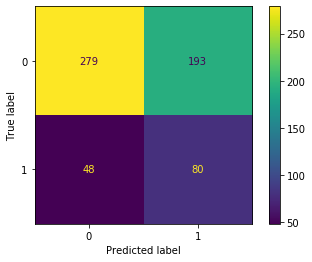

              precision    recall  f1-score   support

           0       0.85      0.59      0.70       472
           1       0.29      0.62      0.40       128

    accuracy                           0.60       600
   macro avg       0.57      0.61      0.55       600
weighted avg       0.73      0.60      0.63       600



In [27]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

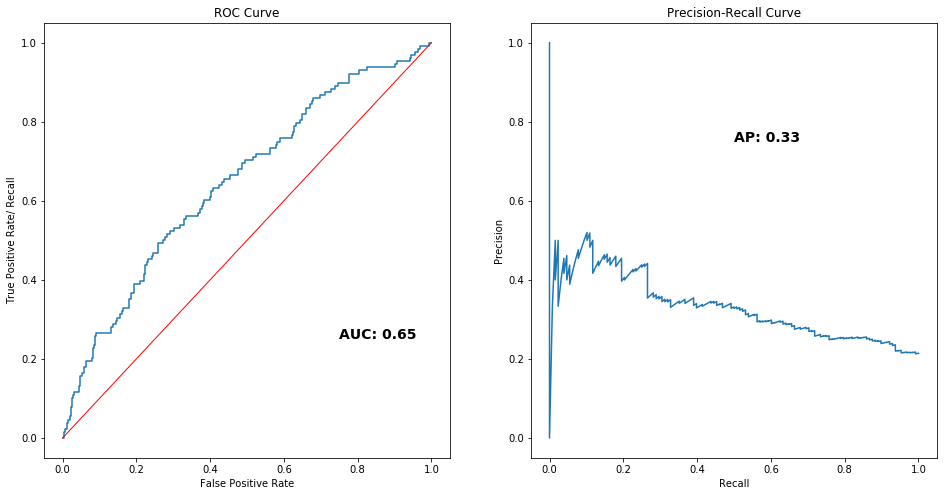

In [28]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))